<a href="https://colab.research.google.com/github/kymjaehong/kaggle/blob/master/Forest_Cover_Type_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from os.path import join
import seaborn as sns

In [ ]:
BASE_DIR = '/content/drive/MyDrive/Lecture_kaggle/exercise_kaggle/camp2022'

In [ ]:
train_path = join(BASE_DIR, 'data', 'train.csv')
test_path = join(BASE_DIR, 'data', 'test.csv')

In [ ]:
data = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 826224 entries, 0 to 826223
Data columns (total 14 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id                                  826224 non-null  int64  
 1   Elevation                           826224 non-null  int64  
 2   Aspect                              826224 non-null  int64  
 3   Slope                               826224 non-null  int64  
 4   Horizontal_Distance_To_Hydrology    817992 non-null  float64
 5   Vertical_Distance_To_Hydrology      793164 non-null  float64
 6   Horizontal_Distance_To_Roadways     793085 non-null  float64
 7   Hillshade_9am                       784779 non-null  float64
 8   Hillshade_Noon                      793109 non-null  float64
 9   Hillshade_3pm                       784866 non-null  float64
 10  Horizontal_Distance_To_Fire_Points  793303 non-null  float64
 11  Soil_Type                 

In [ ]:
data.describe()

,id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Soil_Type,Wilderness_Area,Cover_Type
count,826224.000000,826224.000000,826224.000000,826224.000000,817992.000000,793164.000000,793085.000000,784779.000000,793109.000000,784866.000000,793303.000000,826224.000000,826224.000000,826224.000000
mean,413111.500000,2943.346507,151.517130,15.260949,272.227882,52.673064,1706.496011,211.868308,220.940612,140.612038,1516.416838,10.367157,1.456131,1.912988
std,238510.468744,328.216211,109.858219,8.588512,226.315705,68.186882,1286.145727,30.701996,22.277715,43.710597,1110.210430,12.770907,0.961180,0.796831
min,0.000000,1784.000000,-31.000000,-3.000000,-75.000000,-296.000000,-287.000000,4.000000,56.000000,-51.000000,-267.000000,0.000000,0.000000,1.000000
25%,206555.750000,2702.000000,60.000000,9.000000,111.000000,4.000000,792.000000,198.000000,210.000000,115.000000,735.000000,0.000000,0.000000,1.000000
50%,413111.500000,2932.000000,123.000000,14.000000,214.000000,33.000000,1381.000000,218.000000,224.000000,142.000000,1278.000000,3.000000,2.000000,2.000000
75%,619667.250000,3216.000000,247.000000,20.000000,363.000000,80.000000,2268.000000,233.000000,237.000000,169.000000,1999.000000,21.000000,2.000000,2.000000
max,826223.000000,4322.000000,405.000000,63.000000,1575.000000,628.000000,7666.000000,291.000000,279.000000,271.000000,8006.000000,39.000000,3.000000,4.000000


In [ ]:
label = data['Cover_Type']
#label = label.astype(int)

id = data['id']

In [ ]:
data.drop(columns=['id', 'Cover_Type'], inplace=True)
test.drop(columns=['id'], inplace=True)

In [ ]:
cat_columns = ['Soil_Type', 'Wilderness_Area']
num_columns = [col for col in data.columns if col not in cat_columns]

print('범주형 컬럼: \n{}\n'.format(cat_columns))
print('수치형 컬럼: \n{}\n'.format(num_columns))

범주형 컬럼: 
['Soil_Type', 'Wilderness_Area']

수치형 컬럼: 
['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']



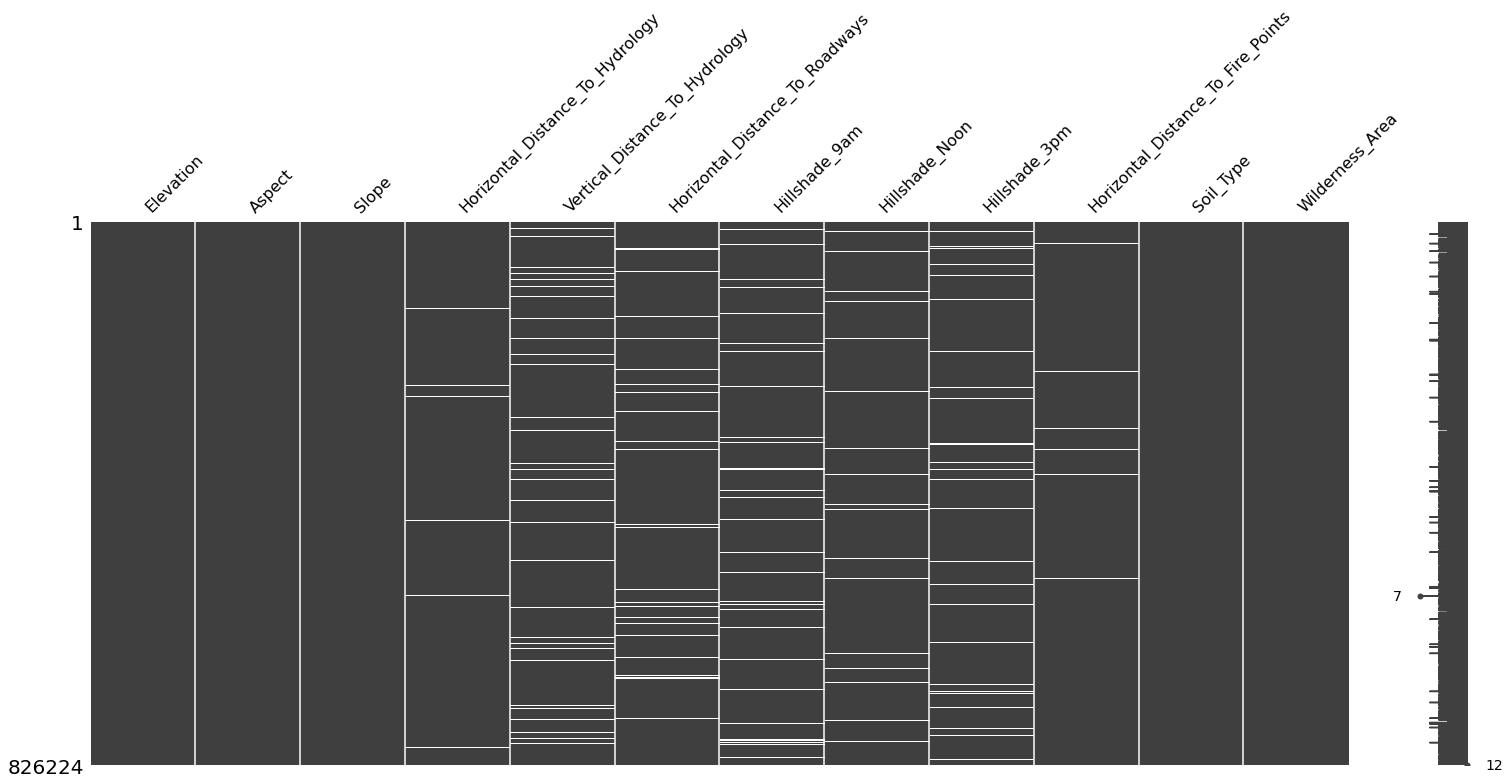

In [ ]:
import missingno as msno

msno.matrix(data)

In [ ]:
data.shape, label.shape

((826224, 12), (826224,))

In [ ]:
test.shape

(550816, 12)

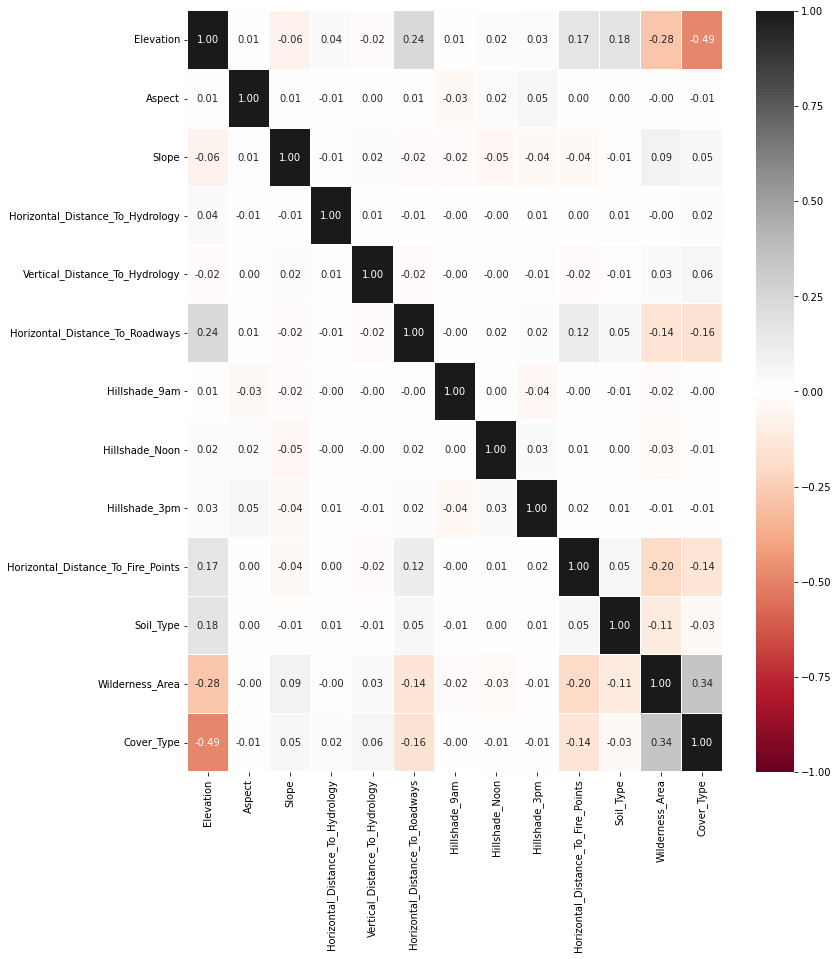

In [ ]:
plt.figure(figsize=(12,14))
sns.heatmap(pd.concat([data, label], axis=1).corr(), vmin=-1, vmax=1, annot=True, linewidths=0.2, fmt='.2f', cmap='RdGy')
plt.show()

In [ ]:
meaningless_cols = [col for col in num_columns if col not in ['Elevation', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']]
print('|상관 계수| < 0.1 컬럼:\n{}'.format(meaningless_cols))

|상관 계수| < 0.1 컬럼:
['Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']


### 전처리 프로세스

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(data, label, test_size=0.3,
                                                      shuffle=True, random_state=42,
                                                      stratify=label)

### index 재정렬

In [ ]:
y_train.reset_index(drop=True, inplace=True)
y_valid.reset_index(drop=True, inplace=True)

In [ ]:
def preprocess(x_train, x_valid, x_test):
  temp_x_train = x_train.copy()
  temp_x_valid = x_valid.copy()
  temp_x_test = x_test.copy()

  temp_x_train.reset_index(drop=True, inplace=True)
  temp_x_valid.reset_index(drop=True, inplace=True)

  # 수치형 결측치 처리
  imputer = IterativeImputer(max_iter=20, random_state=42)

  temp_x_train[num_columns] = imputer.fit_transform(temp_x_train[num_columns])
  temp_x_valid[num_columns] = imputer.transform(temp_x_valid[num_columns])
  temp_x_test[num_columns] = imputer.transform(temp_x_test[num_columns])

  # 상관 계수 0.1이하 스케일링
  scaler = RobustScaler()

  temp_x_train[meaningless_cols] = scaler.fit_transform(temp_x_train[meaningless_cols])
  temp_x_valid[meaningless_cols] = scaler.transform(temp_x_valid[meaningless_cols])
  temp_x_test[meaningless_cols] = scaler.transform(temp_x_test[meaningless_cols])

  # 원 핫 인코딩
  cat_all = pd.concat([temp_x_train[cat_columns],temp_x_valid[cat_columns], temp_x_test[cat_columns]], axis=0)
  ohe = OneHotEncoder(sparse=False)
  ohe.fit(cat_all)

  ohe_columns = list()
  for cols, col in zip(ohe.categories_, cat_columns):
    ohe_columns += [f'{col}_{c}' for c in cols.tolist()]

  cat_train = pd.DataFrame(ohe.transform(temp_x_train[cat_columns]), columns=ohe_columns)
  cat_valid = pd.DataFrame(ohe.transform(temp_x_valid[cat_columns]), columns=ohe_columns)
  cat_test = pd.DataFrame(ohe.transform(temp_x_test[cat_columns]), columns=ohe_columns)

  temp_x_train.drop(columns=cat_columns, inplace=True)
  temp_x_valid.drop(columns=cat_columns, inplace=True)
  temp_x_test.drop(columns=cat_columns, inplace=True)

  temp_x_train = pd.concat([temp_x_train, cat_train], axis=1)
  temp_x_valid = pd.concat([temp_x_valid, cat_valid], axis=1)
  temp_x_test = pd.concat([temp_x_test, cat_test], axis=1)

  return temp_x_train, temp_x_valid, temp_x_test

In [ ]:
#pip install catboost

In [ ]:
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

### feature importance 비교

In [ ]:
x_train, x_valid, _ = preprocess(x_train, x_valid, test)

from sklearn.inspection import permutation_importance

clfs = [
        ['LGBM', LGBMClassifier(n_estimators=1000,learning_rate=0.1, max_depth= 9, reg_alpha= 0.01, reg_lambda=0.01, tree_method='gpu_hist')],
        ['XGBM', XGBClassifier(n_estimators=1000,learning_rate=0.1, max_depth= 9, reg_alpha= 0.01, reg_lambda=0.01, tree_method='gpu_hist')],
        ['CatBoost', CatBoostClassifier(learning_rate=0.1, max_depth=9, l2_leaf_reg=0.01, iterations=1000)]
    ]
vote_clf = VotingClassifier(clfs, voting='soft')
vote_clf.fit(x_train, y_train)

r = permutation_importance(vote_clf, x_valid, y_valid,
                           n_repeats=10,
                           random_state=42)

In [ ]:
for i in r.importances_mean.argsort()[::]:
  #if r.importances_mean[i] - 2 * r.importances_std[i] > 0:        # 좋은 변수를 선별하는 조건문을 지운다.
  print(f"{x_valid.columns[i]:<8}: "
    f"{r.importances_mean[i]:.3f}"
    f" +/- {r.importances_std[i]:.3f}")

In [ ]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{x_valid.columns[i]:<8}: "
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

In [ ]:
# 피쳐 선별
spec_columns = ['Elevation','Soil_Type_0','Horizontal_Distance_To_Roadways','Horizontal_Distance_To_Fire_Points','Wilderness_Area_0',
                'Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Hydrology','Wilderness_Area_2','Soil_Type_38','Soil_Type_1',
                'Soil_Type_3','Soil_Type_37','Soil_Type_39','Soil_Type_21','Soil_Type_22','Soil_Type_2','Soil_Type_32','Soil_Type_9',
                'Soil_Type_31','Soil_Type_34','Soil_Type_12','Wilderness_Area_3','Soil_Type_4','Soil_Type_30','Soil_Type_10','Soil_Type_23',
                'Soil_Type_16','Soil_Type_11','Soil_Type_36','Soil_Type_35','Soil_Type_29','Soil_Type_19','Soil_Type_17','Soil_Type_13',
                'Soil_Type_25','Soil_Type_15','Soil_Type_26','Soil_Type_33','Soil_Type_20','Soil_Type_18','Soil_Type_8','Soil_Type_27','Soil_Type_28']

### 데이터 재 선언

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(data, label, test_size=0.3,
                                                      shuffle=True, random_state=42,
                                                      stratify=label)

In [ ]:
y_train.reset_index(drop=True, inplace=True)
y_valid.reset_index(drop=True, inplace=True)

### kfold

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
val_scores = list()
oof_pred = np.zeros((test.shape[0],4))
n_splits = 5

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

### 학습

In [ ]:
from sklearn.metrics import f1_score, log_loss

In [ ]:
for i, (train_idx, valid_idx) in enumerate(skf.split(data, label)):
    x_train, y_train = data.iloc[train_idx, :], label.iloc[train_idx,]
    x_valid, y_valid = data.iloc[valid_idx, :], label.iloc[valid_idx,]
    
    # 전처리
    x_train, x_valid, x_test = preprocess(x_train, x_valid, test)
    
    # 특정 컬럼만 사용
    x_train = x_train[spec_columns]
    x_valid = x_valid[spec_columns]
    x_test = x_test[spec_columns]
    
    # 모델 정의
    clfs = [['CatBoost', CatBoostClassifier(learning_rate=0.1, max_depth=9, l2_leaf_reg=0.01, iterations=1000)],
        ['LGBM', LGBMClassifier(n_estimators=1000,learning_rate=0.1, max_depth= 9, reg_alpha= 0.01, reg_lambda=0.01, tree_method='gpu_hist')],
        ['XGBM', XGBClassifier(n_estimators=1000,learning_rate=0.1, max_depth= 9, reg_alpha= 0.01, reg_lambda=0.01, tree_method='gpu_hist')]]

    vote_clf = VotingClassifier(clfs, voting='soft')

    
    # 모델 학습
    vote_clf.fit(x_train, y_train)
    
    # 훈련, 검증 데이터 log_loss 확인
    train_logloss = log_loss(y_train, vote_clf.predict_proba(x_train))
    valid_logloss = log_loss(y_valid, vote_clf.predict_proba(x_valid))
    print('{} Fold, train logloss : {:.4f}, validation logloss : {:.4f}'.format(i, train_logloss, valid_logloss))
    
    val_scores.append(valid_logloss)
    
    oof_pred += vote_clf.predict_proba(x_test) / skf.n_splits 

# 교차 검증 정확도 평균 계산하기
print('Cross Validation Score : {:.4f}'.format(np.mean(val_scores)))

In [ ]:
oof_pred
oof_pred.shape

In [ ]:
sub_path = join(BASE_DIR, 'data', 'sample_submission.csv')
sub = pd.read_csv(sub_path)
sub

In [ ]:
sub['Cover_Type'] = oof_pred.argmax(axis=1)+1

In [ ]:
sub

In [ ]:
#sub.to_csv('final_submission.csv', index=False, encoding='cp949')